## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.
C:\Users\amonr\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\amonr\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\amonr\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\amonr\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization, Activation

def build_mlp(input_shape, output_units=10, num_neurons=[64, 32], pre_activate=False):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units,
                                   name='hidden_layer' + str(i+1))(input_layer)
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation('relu')(x)
            else:
                x = Activation('relu')(x)
                x = BatchNormalization()(x)
        else:            
            x = keras.layers.Dense(units=n_units,
                                   name='hidden_layer' + str(i+1))(x)
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation('relu')(x)
            else:
                x = Activation('relu')(x)
                x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = [2, 16, 32, 128]
PRE_ACTIVATE = [True, False]
MOMENTUM = 0.95

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for i, (use_preact, bz) in enumerate(itertools.product(PRE_ACTIVATE, BATCH_SIZE)):
    print("Numbers of exp: %i, use_preact: %s, batch_size: %i" % (i, use_preact, bz))
    model = build_mlp(input_shape=x_train.shape[1:], pre_activate=use_preact)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["acc"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=bz, 
              validation_split=0.2, 
              verbose=1,
              shuffle=True)
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, use_preact: True, batch_size: 2
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 64)                196672    
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 32)                2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
activati

40000/40000 [==============================] - 5s 125us/step - loss: 1.3599 - acc: 0.5156 - val_loss: 1.6409 - val_acc: 0.4309
Epoch 7/10
40000/40000 [==============================] - 5s 126us/step - loss: 1.3319 - acc: 0.5259 - val_loss: 1.5918 - val_acc: 0.4316
Epoch 8/10
40000/40000 [==============================] - 5s 126us/step - loss: 1.3119 - acc: 0.5324 - val_loss: 1.5459 - val_acc: 0.4549
Epoch 9/10
40000/40000 [==============================] - 5s 125us/step - loss: 1.2938 - acc: 0.5384 - val_loss: 1.5788 - val_acc: 0.4564
Epoch 10/10
40000/40000 [==============================] - 5s 128us/step - loss: 1.2694 - acc: 0.5462 - val_loss: 1.5223 - val_acc: 0.4711
Numbers of exp: 3, use_preact: True, batch_size: 128
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
____________________________________________________

40000/40000 [==============================] - 9s 228us/step - loss: 1.7379 - acc: 0.3864 - val_loss: 1.7204 - val_acc: 0.3969
Epoch 3/10
40000/40000 [==============================] - 9s 234us/step - loss: 1.6936 - acc: 0.4022 - val_loss: 1.8208 - val_acc: 0.3587
Epoch 4/10
40000/40000 [==============================] - 9s 222us/step - loss: 1.6514 - acc: 0.4165 - val_loss: 1.7012 - val_acc: 0.4058
Epoch 5/10
40000/40000 [==============================] - 9s 227us/step - loss: 1.6337 - acc: 0.4193 - val_loss: 1.6579 - val_acc: 0.4187
Epoch 6/10
40000/40000 [==============================] - 9s 222us/step - loss: 1.6185 - acc: 0.4306 - val_loss: 1.6121 - val_acc: 0.4317
Epoch 7/10
40000/40000 [==============================] - 9s 219us/step - loss: 1.5969 - acc: 0.4361 - val_loss: 1.6420 - val_acc: 0.4195
Epoch 8/10
40000/40000 [==============================] - 9s 218us/step - loss: 1.5836 - acc: 0.4396 - val_loss: 1.6756 - val_acc: 0.4018
Epoch 9/10
40000/40000 [=====================

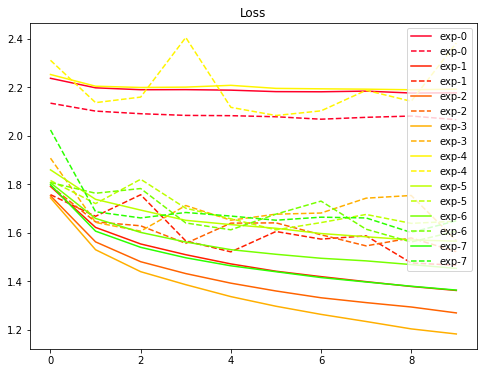

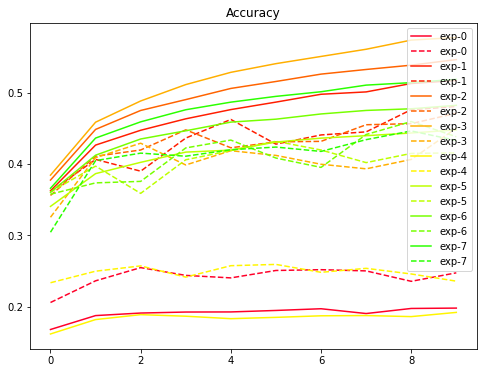

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 20

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()